In [1]:
import numpy as np
from collections import Counter

import matplotlib.cm  as cm
import matplotlib.patches as mpatch
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.metrics import confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split, cross_val_predict


import sys, os
sys.path.append('..')
from utils import data_preprocesados, etiquetas, plot_labels, plot_some_LP

In [2]:
X_all = data_preprocesados()

Del cuaderno anterior aprendimos que podemos identificar entre 4 y 5 grandes clusters para clasificar las señales.
En este cuaderno vamos a combinar los algortimos TSNE y GMM para visualizar y seleccionar aquellas señales que pertenezcan (con una alta probabilidad) a una clase definida. De esta forma vamos a poder comparar señales y clasificar manualmente para tener algunas etiquetas.

## 1. TSNE + GMM

In [3]:
tsne = TSNE(init='pca')
X_valid_2D = tsne.fit_transform(X_all)

In [7]:
n = 7
gmm = GaussianMixture(n_components=n, n_init=10, random_state=45).fit(X_valid_2D)
y_predict = gmm.predict(X_valid_2D)
prob = gmm.predict_proba(X_valid_2D)

labels = list(Counter(y_predict).keys())

print(' Akaike information criterion (AIC): ', f'{gmm.aic(X_valid_2D):.0f}')
print(' Bayesian information criterion (BIC): ', f'{gmm.bic(X_valid_2D):.0f}')
print('\n', Counter(y_predict))

 Akaike information criterion (AIC):  17288
 Bayesian information criterion (BIC):  17491

 Counter({5: 292, 0: 146, 2: 145, 6: 143, 4: 138, 3: 118, 1: 62})


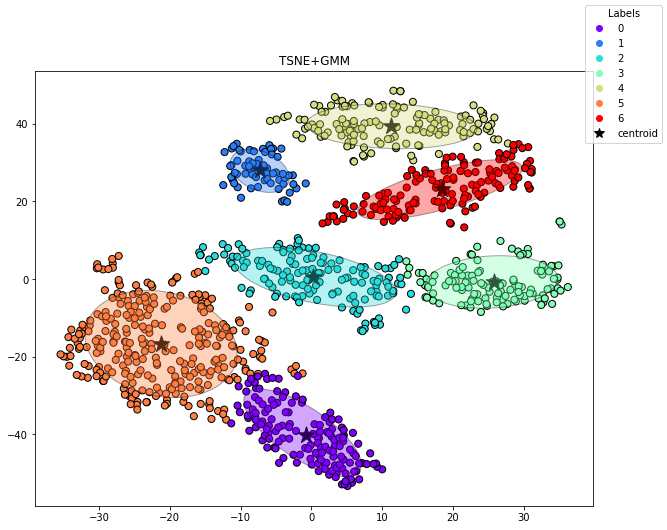

In [8]:
plot_labels(X_valid_2D, y_predict, cmap='rainbow', title='TSNE+GMM', show_centroid=True ,ellipse=(gmm.means_, gmm.covariances_))

In [9]:
y, y_best = np.where(prob>0.995)
y_best_label = list(Counter(y_best).keys())
y_best_label.sort()

print(f'Total: {len(y)}') 
print('Label, nro_LPs')
print('---------------')
for n in y_best_label:
    i = Counter(y_best)[n]
    print(f'{n:^5}', f'{i:^7}')

Total: 557
Label, nro_LPs
---------------
  0     77   
  1     38   
  2     18   
  3     60   
  4     113  
  5     166  
  6     85   


In [ ]:
plot_some_LP(y_best, 2, rand_int=3, y_index=y)

Hemos tenido que reducir el tamaño en el GMM para ir buscando una clasificación balanceada.
Con un 99.5% de probabilid de pertenencia de clase, 557 señales (~50%) pueden ser clasificadas en etiquetas bien balanceadas.

Una comparación visual entre pares de señales nos ha permitido emparejar 97 señales de LP en 15 etiquetas.

In [10]:
y_valid, y_valid_labels = etiquetas()
print('Supervised labels: ', len(y_valid))
print('Sup_label, nro_LPs')
print('------------------')
y_valid_label = list(Counter(y_valid_labels).keys())
y_valid_label.sort()
for n in y_valid_label:
    i = Counter(y_valid_labels)[n]
    print(f'{n:^9}', f'{i:^7}')

Supervised labels:  97
Sup_label, nro_LPs
------------------
    1       28   
    2       10   
    3        4   
    4       30   
    5        3   
    6        3   
    7        2   
    8        3   
    9        2   
   10        2   
   11        2   
   12        2   
   13        2   
   14        2   
   15        2   


In [ ]:
# veamos algunos ejemplos


k_index = np.array(idx)[np.where(np.array(y_valid)==2)]
LP_idxs_a = k_index[np.random.choice(k_index.shape[0], n_LPs)]
print(LP_idxs_a)
plot_LP_list(map(gen.get, LP_idxs_a))


Establecer estas etiquetas no fue sencillo, primero tuvimos que ir comparando entre pares de señales. Cuando estás se daban, se iban guardando. Luego diseñar codigos sencillos que juntaran indices repetidos con el fin de hacer cadenas largas de índices de señales de una misma clase.

Aún así es posible que errores hayan podido cometerse durante esta parte. La complejidad de las comparación es tal que cuando se visualiza el resultado es posible que señales con una misma etiqueta no resulten tan parecidos como uno esperaría.

In [ ]:
n_LP_toshow = 10
sup_label = 1
k_sup_index = np.array(idx)[np.where(np.array(y_valid)==sup_label)] # resultados supervisados
k_sup_index_rand = k_sup_index[np.random.choice(k_sup_index.shape[0], n_LP_toshow, replace=False)]

print('supervised_label: ', sup_label)
print('LP_index,  GMM_label')
print('-------------------')
for kid in k_sup_index_rand:
    print(f'{kid:^8}', '   ', labels[kid])


In [ ]:
print('Sup_label   gmm_label:n_Lps')
print('----------------------')
for i in dlabel:
    k_sup_index = np.array(idx)[np.where(np.array(y_valid)==i)]
    gmm_labels = Counter([labels[kid] for kid in k_sup_index])

    print(f'{i:^9}', dict(gmm_labels))

Estos resultados no son muy prometedores, pero dado que nuestro esfuerzo por etiquetar manualmente las señales por inspección visual tampoco arroja resultados correctos. Vamos a considerar que el modelo GMM logra clasificar bien en familias una gran parte del dataset.

De echo, si tenemos en cuenta unicamente aquellos LPs con prob de pertenencia por arriba del 99.9%, 376 señales (36%) estarían etiquetadas,
esto nos va a permitir entrenar clasificadores 

## 2. LogisticRegrsion / Propagacion de etiquetas

In [11]:
tsne = TSNE(init='pca')
X_valid_2D = tsne.fit_transform(X_all)

Nc = 7
gmm = GaussianMixture(n_components=Nc, n_init=10).fit(X_valid_2D)
y_prob = gmm.predict(X_valid_2D)
prob = gmm.predict_proba(X_valid_2D)
LP_index, Y_labeled = np.where(prob>0.999)

In [12]:
X_labeled = np.empty((len(LP_index), X_all.shape[1]))
X_forlabel = np.empty((X_all.shape[0]-len(LP_index), X_all.shape[1]))
X_forlabel_index = []
y_forlabel = []

nl = 0
nf = 0
for n in range(X_all.shape[0]):
    if n in LP_index:
        X_labeled[nl,:] = X_all[n,:]
        nl += 1
    else:
        X_forlabel[nf,:] = X_all[n,:]
        y_forlabel.append(np.argmax(prob[n]))
        X_forlabel_index.append(n)
        nf += 1

In [13]:
print('Total: ', X_labeled.shape, Y_labeled.shape)
X_train, X_test, y_train, y_test = train_test_split(X_labeled, Y_labeled, test_size=0.25, random_state=15)
print('Entrenamiento: ', X_train.shape) 
print('Validación: ',X_test.shape)

Total:  (414, 16) (414,)
Entrenamiento:  (310, 16)
Validación:  (104, 16)


Recall:  1.00
Precision:  1.00
[[ 72   0   0   0   0   0]
 [  0  22   0   0   0   0]
 [  0   0  25   0   0   0]
 [  0   0   0  40   0   0]
 [  0   0   0   0 102   0]
 [  0   0   0   0   0  49]]


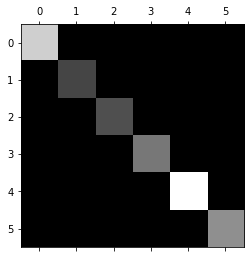

In [14]:
lr = LogisticRegression(penalty='l2', fit_intercept=False, C=1.0)
lr.fit(X_train, y_train)
y_train_pred_CG = cross_val_predict(lr, X_train, y_train, cv=5)
conf_cm = confusion_matrix(y_train, y_train_pred_CG)
plt.matshow(conf_cm, cmap='Greys_r')
print("Recall: ", f"{recall_score(y_train, y_train_pred_CG, average='weighted'):.2f}")
print("Precision: ", f"{precision_score(y_train, y_train_pred_CG, average='weighted'):.2f}")
print(conf_cm)

El modelo es muy preciso y practicamente no se equivoca, pero ¿generalizara bien?

[[25  0  0  0  0  0]
 [ 0  4  0  0  0  0]
 [ 0  0  8  0  0  0]
 [ 0  0  1  8  0  0]
 [ 0  0  0  0 47  0]
 [ 0  0  0  1  0 10]]
Recall:  0.98
Precision:  0.98


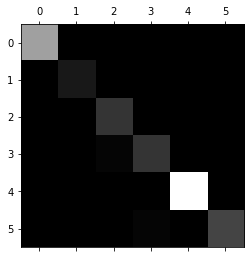

In [15]:
conf_cm_test = confusion_matrix(y_test, lr.predict(X_test))
print(conf_cm_test)
plt.matshow(conf_cm_test, cmap='Greys_r')
print("Recall: ", f"{recall_score(y_test, lr.predict(X_test), average='weighted'):.2f}")
print("Precision: ", f"{precision_score(y_test, lr.predict(X_test), average='weighted'):.2f}")

Pues parece que generaliza muy bien. 

Vamos a ver si es capaz de clasificar las demas señales y vamos a comparar con el GMM

[[  0   0  17   0   0  88  31]
 [  0  36   0   0   0   0   5]
 [  0   0  28   0   5   0   0]
 [  0   0   0  66   2  32   0]
 [  0   1   6   0  74   6  10]
 [  0   0   1   2   0 150   1]
 [  0   0   0   0   1   0  68]]
Recall:  0.67
Precision:  0.58


/home/ifm/.local/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


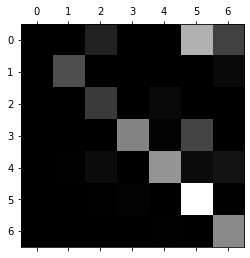

In [16]:
y_result = lr.predict(X_forlabel)
conf_cm_gmm = confusion_matrix(y_forlabel, y_result)
print(conf_cm_gmm)
print("Recall: ", f"{recall_score(y_forlabel, y_result, average='weighted'):.2f}")
print("Precision: ", f"{precision_score(y_forlabel, y_result, average='weighted'):.2f}")
plt.matshow(conf_cm_gmm, cmap='Greys_r')

Hay una etiqueta que falla que tiene que ver con la poca de densidad de datos. 
Por otro lado, vemos que el clasificador podría andar bien

In [ ]:
norm = mcolors.Normalize(0, Nc-1)
fig, ax = plt.subplots(1,1, figsize=(9,9))

X_joint = np.concatenate((X_forlabel, X_labeled))
Y_joint = np.concatenate((y_result, Y_labeled))

tsne_joint = TSNE(init='pca')
X_joint_2D = tsne_joint.fit_transform(X_joint)

ax.scatter(X_joint_2D[:X_forlabel.shape[0],0], X_joint_2D[:X_forlabel.shape[0],1], marker='s', c=y_result, cmap='jet', norm=norm, s=20)
ax.scatter(X_joint_2D[X_forlabel.shape[0]:,0], X_joint_2D[X_forlabel.shape[0]:,1], marker='o', ec='k', c=Y_labeled, cmap='jet', norm=norm, s=20)
h = [plt.Line2D([0], [0], linestyle="none", marker="o", c=cm.get_cmap('jet')(norm(c)), label=c, alpha=1) for c in range(Nc)]
fig.legend(h, range(Nc), title='Labels')

No hay mucha diferencia entre el resultado obtenido entre TSNE+GMM y el clasificador.
Las clases 0, 1 y 2 son las que más les cuesta separar.

In [ ]:
gen = LP_datos()
n_cluster = 0
n_LPs = 3

# Clasificador
lp_idx_cluster = np.array(X_forlabel_index)[np.where(y_result==n_cluster)[0]]
idx = lp_idx_cluster[np.random.choice(len(lp_idx_cluster), n_LPs)]
print(n_cluster, idx)
plot_LP_list(map(gen.get, idx))


## Conclusión

La combinación TSNE+GMM puede que sea mejor que el clasificador Logistico para clasificar las señales.
El principal inconveniente en el clasificador fue que los datos de entrenamiento estuvieron desbalanceados y ciertas clases como la 0, 1, y 2 no se pudieron separar correctamente, o al menos, de acuerdo al gráfico dado por el TSNE+GMM. 
